# 1. Introduction

This notebook presents a solution to the competition "The Energy-Efficient Ghosts of Holiday Past".
- Competition website: https://thinkonward.com/app/c/challenges/ghosts-of-holidays-past
- Team: Energy Friendly Ghosts

## Solution overview
The aim of this competition is to suggest the cheapest 4-hour window for Ebenezer Scrooge to host his party, thereby minimizing his electricity expenses. Achieving this goal simply requires conducting an analysis based on historical consumption patterns and their correlation with weather conditions.

Ebenezer Scrooge might also want to know the party cost therefore it is neccessary to build a machine learning (ML) pipelines to estimate the power consumptions during the holiday period. Figure bellow presents the Energy Friendly Ghosts' ML pipelines.

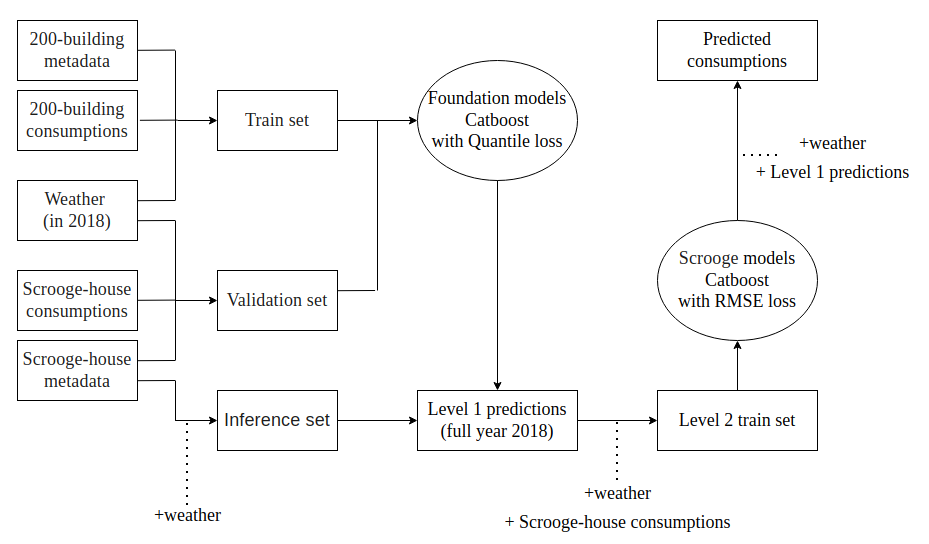

The ML system consists of two levels: Foundation models and Scrooge models. 
- Foundation models, at level 1, rely on building characteristics (metadata) and weather conditions.
  - Ideally, weather data for all building locations would be available, but this is prohibitively costly. Therefore, we only gather weather information at the Scrooge building's location. Consequently, we must adjust the loss function of the models to enhance prediction accuracy for the next level. The forecasted power consumption for the Scrooge building throughout the entire year of 2018 reflects a combination of all significant factors pertaining to the building itself and prevailing weather conditions.
  - Techincal details
    - The training set was compiled from the historical consumptions of all 200 buildings, while the validation set exclusively comprises data from the Scrooge building. This approach ensures unbiased predictions, which are suitable for utilization in the subsequent level.
    - Based on the analysis, we determine that the party's start time should be 20:00; thus, we focus solely on building models for consumption from 20:00 to midnight.
    - To smooth consumptions and minimize dataset size, we aggregated consumption data hourly for model training.
    - The ML algorithm used is CatBoost with quantile loss.     

<br>

- The Scrooge models serve as a machine learning calibration function, mapping level 1 predictions to values that closely resemble the actual consumptions.
  - Techincal details
    - Train set is based on the historical consumptionsof the Scrooge building.
    - In the train set, we retain only the temperature alongside the level 1 predictions. This decision is primarily due to the limited number of data points available for model training. Therefore, we must restrict the number of features to ensure the predictive capability of the ML models.
    - The ML algorithm used is CatBoost with RMSE loss (which is closed to the competition metrics).


<br>
In order to determine the most economical four-hour window, we compute the total party cost for each day and select the date with the lowest cost. Additionally, since our forecast is at the hourly level, we need to convert it to the quarter-hour level. There are few ways to do it

- <b>interpolate0_equally_divide</b>: This method involves simply dividing a predicted value into four equal power consumptions. While straightforward, it fails to capture consumption relationships and doesn't achieve the highest score.
- <b>interpolate4_ab</b>: This approach interpolates quarterly consumptions by establishing a trend between each pair and placing four points at equal distances. It offers a reasonable solution and achieves a good score.
- <b>interpolate8_ab</b>: This method drops the consumptions along the trend in a shapely manner. While it yields our best score on the Leaderboard, we suspect it may overfit to the Leaderboard data.

## Interesting findings during model developement

- There are some features that we think they should be very usefull but turn out they do not contribute to the forecasting capabilities
  - Lagged features: While this feature is deemed significant in isolation, its incorporation into the model did not ultimately lead to improved outcomes overall.
  - Hour feature (as a categorical feature)
  - Weekday feature (as a categorical feature)
  - Evening feature (binary feature indicating if the time is after 20:00)

<br>

- Unexpected discoveries during the initial phases of our analysis.
  - Heavy heating in the evening often starts at 20:00. Wouldn't it be more cost-effective to heat before 18:00 and suspend during peak hours?
  - There are no identifiable patterns indicating a significant reduction or cessation of heating.

## Reflection on the Real Time Data Ingestion Platform
- Good
  - The framework proves highly beneficial for organizing system pipelines into distinct layers, including data queries, data transformation, and ML modelling.
  - It offers a convenient way for stacking pipelines, particularly when integrated with PySpark.
  
- Things can be improved
  - Better documentation, particularly regarding installation and "hidden" dependencies.

## External data sources
This notebook requires weather data from https://home.openweathermap.org/. Therefore
- Either run the 001-External-Data-Weather-Downloader.ipynb notebook with a valid api_key
- Either extract the provided weather.zip file into weather sub directory


## Python enviroment, Configuration and Prepration

This kernel uses python 3.9.18 and some python libraries listed in the requirements.txt. The following command lines should be able to generate the correct enviroment. 

- conda create -n py39_holiday python=3.9.18
- conda activate py39_holiday
- pip install -r requirements.txt

Notes:
- There are some dependencies of <b>rtdip_sdk</b> and <b>pyspark</b>, which are not detected by pipreqs.
- Pyspark also requires <b>java</b>. Please install OpenJDK Runtime Environment (openjdk) version "1.8.0_402".

In [1]:
!which python
!python --version
!java -version

!conda list -e > requirements-longer-version.txt

/home/motoki/miniconda3/envs/py39_holiday/bin/python
Python 3.9.18
openjdk version "1.8.0_402"
OpenJDK Runtime Environment (build 1.8.0_402-8u402-ga-2ubuntu1~22.04-b06)
OpenJDK 64-Bit Server VM (build 25.402-b06, mixed mode)


In [2]:
import datetime
time_zone = datetime.datetime.now(datetime.timezone(datetime.timedelta(0))).astimezone().tzinfo
time_zone = str(time_zone)
print(f"Machine time zone: {time_zone}")
!date

time_zone = "UTC"
print(f"Notebook timezone: {time_zone}")

Machine time zone: UTC
mer. 10 avril 2024 15:48:36 UTC
Notebook timezone: UTC


In [3]:
input_dir = "./"

target_input_dir = f"{input_dir}/ghosts-of-holidays-past-train-data/data"
weather_input_dir = f"{input_dir}/weather"

In [4]:
target_cols = [ "out.electricity.heating_hp_bkup.energy_consumption", 
                "out.electricity.heating.energy_consumption", 
                "out.electricity.plug_loads.energy_consumption"]
target_spark_cols = [f"`{c}`" for c in target_cols]
timestamp_col = "timestamp"
bldg_id_col = "bldg_id"

# From 6:00 pm to 10:00 pm, the rate is $0.35 per kWh; 
# outside of this period, the rate stands at $0.20 per kWh.
power_unit_rush_hours = [18,19,20,21] # 18-22 
power_unit_rush_hours_cost = 0.35 # coin / KWH
power_unit_cost = 0.2 # coin / KWH

party_power_fraction = 0.3 # 30%
party_extra_power_unit = 2 # KWH

party_duration = 4 # hours
party_min_start_hour = 17
party_max_start_hour = 20

winter_months = [1,2,3,10,11,12]

In [5]:
buffer_dir = "workspace/buffer"
!mkdir -p $buffer_dir

models_dir = "workspace/models"
!mkdir -p $models_dir

subs_dir = "workspace/subs"
!mkdir -p $subs_dir

In [6]:
# Selection based on EDA
foundation_config = {
    "hourly_aggregation": True,
    "months_selected": winter_months[:],
    "hours_selected": [20,21,22,23],
}

print(foundation_config)

dict_foundation_filename = f"{models_dir}/dict_foundation_quantile.pickle"
print(dict_foundation_filename)

dict_model_scrooge_bldg_filename = f"{models_dir}/dict_model_scrooge_bldg.pickle"
print(dict_model_scrooge_bldg_filename)

{'hourly_aggregation': True, 'months_selected': [1, 2, 3, 10, 11, 12], 'hours_selected': [20, 21, 22, 23]}
workspace/models/dict_foundation_quantile.pickle
workspace/models/dict_model_scrooge_bldg.pickle


In [7]:
# Selection based on EDA
scrooge_config = {
    "hourly_aggregation": True,
    "months_selected": [1,2,3,4,5,6,7,8,9,10,11,12],
    "hours_selected": [20,21,22,23],
}

print(scrooge_config)

dict_scrooge_filename = f"{models_dir}/dict_scrooge_model.pickle"
print(dict_scrooge_filename)

{'hourly_aggregation': True, 'months_selected': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours_selected': [20, 21, 22, 23]}
workspace/models/dict_scrooge_model.pickle


In [8]:
sub_filename = f"{subs_dir}/sub_scrooge_bldg_party.csv"
print(sub_filename)

workspace/subs/sub_scrooge_bldg_party.csv


In [9]:
import os

import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Union
import glob
import pickle
import random

import functools
import operator

from pyspark.sql import SparkSession, Row, functions as SF
from pyspark.sql.window import Window
from pyspark.sql.dataframe import DataFrame as PySparkDataFrame
from pyspark.sql.types import StringType

from pandas import DataFrame as PandasDataFrame
import datetime

In [10]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 10})

import warnings
warnings.filterwarnings('ignore')

In [11]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
import catboost
from catboost import CatBoostRegressor

In [12]:
import rtdip_sdk
from rtdip_sdk.pipelines.transformers import TransformerInterface
import rtdip_sdk.pipelines.transformers as transformers

In [13]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 2024
set_seed(SEED)

In [14]:
spark = (SparkSession
    .builder
    .appName("Python Spark Data Query")
    .config("spark.some.config.option", "some-value")
    .config("spark.executor.memory", "32g")
    .config("spark.driver.memory", "32g")
    .config("spark.memory.offHeap.enabled", True)
    .config("spark.memory.offHeap.size","16g")   
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/10 15:48:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2. Identify the continuous four-hour window 

Identify the continuous four-hour window that offers the most cost-effective electricity rates for Scrooge's Party.

## Transformers using rtdip sdk TransformerInterface

In [15]:
def unionAll(sfs):
    return functools.reduce(lambda sf1,sf2: sf1.union(sf2), sfs) 

class TargetDataLoader(TransformerInterface):

    def __init__(self, spark, hdfs_location, keys, extension=".parquet") -> None:
        self.spark = spark
        
        self.hdfs_location = hdfs_location
        self.keys = keys
        self.extension = extension

    @staticmethod
    def system_type():
        return SystemType.PYSPARK

    @staticmethod
    def libraries():
        libraries = Libraries()
        return libraries

    @staticmethod
    def settings() -> dict:
        return {}

    def pre_transform_validation(self):
        return True

    def post_transform_validation(self):
        return True

    def transform(self) -> PySparkDataFrame:
        sfs = []
        for key in self.keys:
            sf = self.spark.read.parquet(f"{self.hdfs_location}/{key}{self.extension}")
            sf = sf.withColumn("key", SF.lit(key))
            sfs.append(sf)
        return unionAll(sfs)
    

class TargetSelector(TargetDataLoader):

    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface],
                     is_timestamp_adjusted=True,
                     months_selected=None, hours_selected=None) -> None:
        self.sf = sf
        self.is_timestamp_adjusted = is_timestamp_adjusted
        
        self.months_selected = months_selected
        self.hours_selected = hours_selected

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()

        sf3 = (sf2
            .withColumn("bldg_id", SF.col("key"))
               
            .withColumn("timestamp", SF.to_timestamp( SF.col("timestamp") ))
            .withColumn("timestamp_start", SF.col("timestamp") + SF.expr('INTERVAL -15 minutes'))
        
            .withColumn("month", SF.month( SF.col("timestamp_start") ))
            .withColumn("date", SF.to_date( SF.col("timestamp_start") ))
            .withColumn("hour", SF.hour( SF.col("timestamp_start") ))
            .withColumn("minute", SF.minute( SF.col("timestamp_start") ))
        )

        if self.is_timestamp_adjusted:
            sf3 = (sf3
                .withColumn("timestamp", SF.col("timestamp_start"))
            )
            
        if self.months_selected is not None:
            sf3 = (sf3
                .filter(SF.col("month").isin(self.months_selected))
            )
            
        if self.hours_selected is not None:
            sf3 = (sf3
                .filter(SF.col("hour").isin(self.hours_selected))
            )

        view_cols = ["bldg_id", "timestamp"]
        view_cols += ["month", "date", "hour", "minute"]
        view_cols += target_spark_cols
        
        sf3 = (sf3
            .select(view_cols)
        )
        return sf3


class PowerCostCalculator(TargetDataLoader):

    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface]) -> None:
        self.sf = sf

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()

        sf_cost = (sf2
            .withColumn("power_init", 
                    functools.reduce(operator.add, 
                                     [SF.col(x) for x in target_spark_cols]))

            .withColumn("power_price", 
                        SF.when( SF.col("hour").isin(power_unit_rush_hours), power_unit_rush_hours_cost)
                        .otherwise(power_unit_cost))
            .withColumn("party_power", 
                SF.col("power_init")*party_power_fraction + SF.lit(party_extra_power_unit/4)) # 15mins
            .withColumn("party_cost", SF.col("party_power")*SF.col("power_price"))
        )
        return sf_cost

class PartyCostCalculator(TargetDataLoader):

    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface]) -> None:
        self.sf = sf

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()

        sf_cost = sf2

        # Party duration is 4 hours
        w = Window.orderBy(SF.col("timestamp").cast('long')).rangeBetween(0, party_duration*3600-15*60)
        sf_party_cost = (sf_cost
            .withColumn("party_cost_sum", SF.sum("party_cost").over(w))
        )

        view_cols = ["bldg_id", "timestamp"]
        view_cols += ["month", "date", "hour", "minute"]
        view_cols += ["party_cost_sum"]

        sf_party_cost = (sf_party_cost
            .select(view_cols)
        )
        return sf_party_cost
        
class PartyDailySlotFinder(TargetDataLoader):

    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface]) -> None:
        self.sf = sf

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()

        sf_party_cost = sf2
        sf_party_cost_daily_min = (sf_party_cost
            .filter(
                (SF.col("hour") >= party_min_start_hour) & 
                ((SF.col("hour") < party_max_start_hour) | 
                     (SF.col("hour") == party_max_start_hour) & (SF.col("minute")==0))
            )
            .groupby("date").agg(SF.min("party_cost_sum").alias("party_cost_sum"))
        )
        sf_party_cost_daily_min_extra = (
            sf_party_cost_daily_min.join(
                sf_party_cost, on=["date", "party_cost_sum"]
            )
        )

        return sf_party_cost_daily_min_extra

## Happy start moment
- Question: If we would organise party every single day, when should we start ?
- Answer: Either at 17:00 or at 20:00

In [16]:
hdfs_location = target_input_dir
keys = ["scrooge_bldg"]
    
sf_party_cost_calculator = PartyCostCalculator(
    PowerCostCalculator(
        TargetSelector(
            TargetDataLoader(
                spark, hdfs_location, keys, extension=".parquet"
            ),
            is_timestamp_adjusted=True,
            months_selected=None, 
            hours_selected=None
        ),
    )
)

df_party_cost_daily_min_extra = PartyDailySlotFinder(
    sf_party_cost_calculator
).transform().toPandas()

df_party_cost_daily_min_extra

24/04/10 15:48:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:48:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:48:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:48:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:48:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:48:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 1

,date,party_cost_sum,bldg_id,timestamp,month,hour,minute
0,2018-01-01,5.039322,scrooge_bldg,2018-01-01 17:00:00,1,17,0
1,2018-01-02,4.501375,scrooge_bldg,2018-01-02 20:00:00,1,20,0
2,2018-01-03,4.127791,scrooge_bldg,2018-01-03 17:00:00,1,17,0
3,2018-01-04,4.145766,scrooge_bldg,2018-01-04 20:00:00,1,20,0
4,2018-01-05,5.090654,scrooge_bldg,2018-01-05 20:00:00,1,20,0
...,...,...,...,...,...,...,...
350,2018-12-17,3.116151,scrooge_bldg,2018-12-17 20:00:00,12,20,0
351,2018-12-18,3.487223,scrooge_bldg,2018-12-18 17:00:00,12,17,0
352,2018-12-19,3.231859,scrooge_bldg,2018-12-19 17:00:00,12,17,0
353,2018-12-20,2.946400,scrooge_bldg,2018-12-20 20:00:00,12,20,0


In [17]:
df_party_cost_daily_min_extra.groupby(["month", "hour", "minute"])["date"].count()

month  hour  minute
1      17    0         10
       20    0         21
2      17    0          9
       20    0         19
3      17    0          3
       20    0         28
4      17    0          1
       20    0         29
5      20    0         31
6      20    0         30
7      20    0         31
8      20    0         31
9      20    0         30
10     20    0         31
11     17    0          8
       20    0         22
12     17    0         11
       20    0         10
Name: date, dtype: int64

## Correlation between party expenses and weather conditions

### Weather data

In [18]:
class WeatherDataLoader(TransformerInterface):

    def __init__(self, spark, weather_location_dir) -> None:
        self.spark = spark
        self.weather_location_dir = weather_location_dir

    @staticmethod
    def system_type():
        return SystemType.PYSPARK

    @staticmethod
    def libraries():
        libraries = Libraries()
        return libraries

    @staticmethod
    def settings() -> dict:
        return {}

    def pre_transform_validation(self):
        return True

    def post_transform_validation(self):
        return True

    @staticmethod
    def read_weather_json(weather_filename):
        with open(weather_filename) as json_file:
            json_data = json.load(json_file)

        rs = {}
        for k, v in json_data.items():
            if k in ["data", "weather"]:
                continue
            rs[k] = v

        for k, v in json_data["data"][0].items():
            if k in ["data", "weather"]:
                continue
            rs[k] = v

        short_filename = weather_filename.split("/")[-1]
        ts_filename = "_".join(short_filename.split("_")[1:3])
        rs["ts_filename"] = ts_filename

        return rs

    def transform(self) -> PySparkDataFrame:
        weather_filenames = glob.glob(f"{self.weather_location_dir}/*.json")
        
        rows = [WeatherDataLoader.read_weather_json(weather_filename) for weather_filename in weather_filenames]
        rows_json = self.spark.sparkContext.parallelize(rows)
        sf = self.spark.read.json(rows_json)
        
        return sf
    
class WeatherTemperatureTransformer(WeatherDataLoader):
    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface],
                            temperature_cols=["temp", "feels_like"], K=273.15) -> None:
        self.sf = sf
        self.temperature_cols = temperature_cols
        self.K = K

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()
            
        sf3 = sf2
        for c in self.temperature_cols:
            sf3 = sf3.withColumn(c, SF.col(c)-self.K)
        return sf3

class WeatherExtractor(WeatherDataLoader):
    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface],
                        hours_selected, minutes_selected=[0]) -> None:
        self.sf = sf
        self.hours_selected = hours_selected
        self.minutes_selected = minutes_selected

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()
            
        view_cols = ["timestamp", "lat", "lon", "timezone"]
        not_selected_cols = ["dt", "timezone_offset"]
        selected_cols = view_cols + [c for c in sf2.columns if c not in view_cols + not_selected_cols]
  
        sf3 = (sf2
               # .withColumn("timestamp", SF.to_timestamp(SF.col("dt")))
               .withColumn("timestamp", 
                    SF.to_utc_timestamp(
                           SF.to_timestamp(SF.col("ts_filename"), "yyyyMMdd_HHmmss"), time_zone
                    )
               )
               .select(selected_cols)
        )

        if self.hours_selected is not None:
            sf3 = (sf3
                .filter(SF.hour(SF.col("timestamp")).isin(self.hours_selected))
            )

        if self.minutes_selected is not None:
            sf3 = (sf3
                .filter(SF.minute(SF.col("timestamp")).isin(self.minutes_selected))
            )

        view_cols = ["timestamp", "temp", "feels_like", "pressure"]
        view_cols += ["humidity", "dew_point", "wind_speed", "wind_deg"]

        sf3 = (sf3
            .select(view_cols)
        )
        return sf3

In [19]:
weather_location_dir = weather_input_dir

weather_extractor_for_party = WeatherExtractor(
    WeatherTemperatureTransformer(
        WeatherDataLoader(
            spark, weather_location_dir,
        )
    ),
    hours_selected=[17,20], minutes_selected=[0]
)
    
df_weather_party = weather_extractor_for_party.transform().toPandas()
df_weather_party

,timestamp,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg
0,2018-08-09 17:00:00,28.10,32.03,1008,78,297.05,3.60,250
1,2018-01-04 17:00:00,-2.94,-9.79,991,91,269.09,7.20,360
2,2018-07-29 20:00:00,28.10,28.30,1017,47,288.89,4.63,290
3,2018-11-05 20:00:00,11.80,10.81,1029,68,279.24,4.12,110
4,2018-02-25 17:00:00,4.42,1.08,1021,87,275.60,4.12,100
...,...,...,...,...,...,...,...,...
725,2018-12-06 20:00:00,4.14,-0.28,1018,44,266.92,6.20,260
726,2018-01-08 17:00:00,-0.05,-6.87,1021,40,262.42,9.30,220
727,2018-03-08 20:00:00,2.77,-0.96,1001,81,273.01,4.12,280
728,2018-08-31 17:00:00,23.10,23.03,1027,60,288.07,5.70,50


In [20]:
df_party_cost_with_weather = (
    pd.merge(
        df_party_cost_daily_min_extra, df_weather_party, on="timestamp"
    ).sort_values("timestamp").reset_index(drop=True)
)
    
df_party_cost_with_weather

,date,party_cost_sum,bldg_id,timestamp,month,hour,minute,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg
0,2018-01-01,5.039322,scrooge_bldg,2018-01-01 17:00:00,1,17,0,-12.96,-19.96,1024,43,251.22,6.20,300
1,2018-01-02,4.501375,scrooge_bldg,2018-01-02 20:00:00,1,20,0,-7.19,-14.19,1024,33,253.79,5.70,260
2,2018-01-03,4.127791,scrooge_bldg,2018-01-03 17:00:00,1,17,0,-3.19,-6.91,1026,43,260.31,2.60,210
3,2018-01-04,4.145766,scrooge_bldg,2018-01-04 20:00:00,1,20,0,-0.85,-7.74,980,91,271.17,8.80,340
4,2018-01-05,5.090654,scrooge_bldg,2018-01-05 20:00:00,1,20,0,-9.25,-16.25,1000,44,254.92,12.40,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2018-12-17,3.116151,scrooge_bldg,2018-12-17 20:00:00,12,20,0,4.21,-0.39,1000,83,274.73,6.71,292
351,2018-12-18,3.487223,scrooge_bldg,2018-12-18 17:00:00,12,17,0,-2.11,-9.11,1010,50,263.00,10.28,324
352,2018-12-19,3.231859,scrooge_bldg,2018-12-19 17:00:00,12,17,0,0.53,-2.57,1018,44,263.97,2.68,286
353,2018-12-20,2.946400,scrooge_bldg,2018-12-20 20:00:00,12,20,0,9.33,6.33,1018,52,273.14,6.20,190


### Correlation
It is clear that there exists a (negative) relationship between temperature and party expenses.

Correlation: -0.8987460626451302



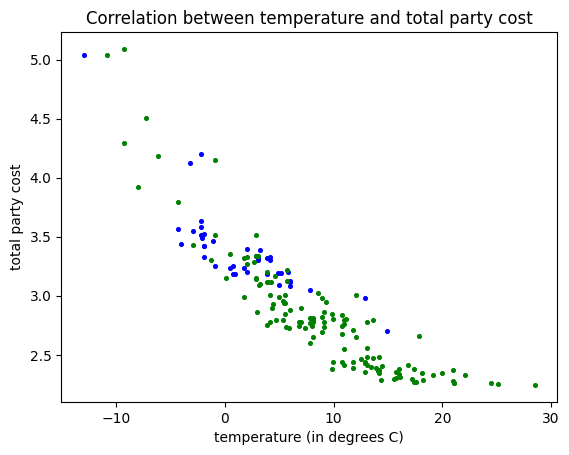

In [21]:
df_run_months = df_party_cost_with_weather[df_party_cost_with_weather["month"].isin(winter_months)]

print("Correlation:", df_run_months["party_cost_sum"].corr(df_run_months["temp"]))
print("")

mark_size = 7

df_run = df_run_months[(df_run_months["hour"] == 17)]
plt.scatter(df_run["temp"], df_run["party_cost_sum"], color='blue', s=mark_size)

df_run = df_run_months[(df_run_months["hour"] == 20)]
plt.scatter(df_run["temp"], df_run["party_cost_sum"], color='green', s=mark_size)

plt.title("Correlation between temperature and total party cost");
plt.xlabel('temperature (in degrees C)')
plt.ylabel('total party cost')

plt.show()

## Happy moment in a window of 11 days

In [22]:
df_party_cost_with_weather2 = df_party_cost_with_weather.copy()
# df_party_cost_with_weather2["date"] = df_party_cost_with_weather2["date"].apply(lambda x: str(x))

all_dates = list(df_party_cost_with_weather2["date"].unique())

nb_days_size = 11
nb_rows_per_days = df_party_cost_with_weather2.shape[0] / len(all_dates)

print(all_dates[:3])
print(nb_rows_per_days)

[datetime.date(2018, 1, 1), datetime.date(2018, 1, 2), datetime.date(2018, 1, 3)]
1.0


In [23]:
party_timestamp_plans = {}

for date in tqdm(all_dates):
    end_date = date + datetime.timedelta(days=nb_days_size)
    selected_rows = (df_party_cost_with_weather2["date"] >= date) & (df_party_cost_with_weather2["date"] < end_date) 
    df_run = df_party_cost_with_weather2[selected_rows]

    if df_run.shape[0] == nb_days_size*nb_rows_per_days:
        row = df_run.iloc[df_run["party_cost_sum"].argmin()]
        party_timestamp_plans[date] = row["timestamp"]
len(party_timestamp_plans)

100%|████████████| 355/355 [00:00<00:00, 946.70it/s]


345

In [24]:
df_party_timestamp_plans = pd.DataFrame.from_dict(party_timestamp_plans, orient='index')
df_party_timestamp_plans = df_party_timestamp_plans.reset_index()
df_party_timestamp_plans.columns = ["date", "timestamp_plan"]
df_party_timestamp_plans["date_plan"] = df_party_timestamp_plans["timestamp_plan"].dt.date
df_party_timestamp_plans["hour_plan"] = df_party_timestamp_plans["timestamp_plan"].dt.hour
df_party_timestamp_plans

,date,timestamp_plan,date_plan,hour_plan
0,2018-01-01,2018-01-11 20:00:00,2018-01-11,20
1,2018-01-02,2018-01-12 20:00:00,2018-01-12,20
2,2018-01-03,2018-01-12 20:00:00,2018-01-12,20
3,2018-01-04,2018-01-12 20:00:00,2018-01-12,20
4,2018-01-05,2018-01-12 20:00:00,2018-01-12,20
...,...,...,...,...
340,2018-12-07,2018-12-15 20:00:00,2018-12-15,20
341,2018-12-08,2018-12-15 20:00:00,2018-12-15,20
342,2018-12-09,2018-12-15 20:00:00,2018-12-15,20
343,2018-12-10,2018-12-15 20:00:00,2018-12-15,20


In [25]:
print(df_party_timestamp_plans[df_party_timestamp_plans["hour_plan"] == 17])
df_party_timestamp_plans.groupby("hour_plan")["date"].count().reset_index()

           date      timestamp_plan   date_plan  hour_plan
336  2018-12-03 2018-12-03 17:00:00  2018-12-03         17


,hour_plan,date
0,17,1
1,20,344


### Let's deep dive into the only date where the hour_plan is 17:00

In [26]:
class PartyCostDisplay(TargetDataLoader):

    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface],
                                         date_selected) -> None:
        self.sf = sf
        self.date_selected = date_selected
        
    def transform(self) -> None:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()

        sf_party_cost = sf2

        sf_party_cost_show = (sf_party_cost
            .filter(
                (SF.col("date") == self.date_selected) & 
                SF.col("hour").isin([17,20]) & 
                (SF.col("minute")==0)
            )
        )

        print(sf_party_cost_show.toPandas())

PartyCostDisplay(sf_party_cost_calculator,
                date_selected="2018-12-03").transform()

24/04/10 15:49:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:49:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:49:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/10 15:49:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


        bldg_id           timestamp  month        date  hour  minute  \
0  scrooge_bldg 2018-12-03 17:00:00     12  2018-12-03    17       0   
1  scrooge_bldg 2018-12-03 20:00:00     12  2018-12-03    20       0   

   party_cost_sum  
0        2.702161  
1        2.720221  


### Conclusion
- During the whole historical consumption, except a single time, cost-effective parties  start at 20:00.
- On that exceptional date: The total party cost remains nearly unchanged whether we commence at 17:00 or 20:00.
  
<b>Therefore, we may infer that all cost-effective parties typically start at 20:00.</b>

## Weather during Christmas

In [27]:
df_weather_party2 = df_weather_party.copy()
df_weather_party2["date"] = df_weather_party2["timestamp"].dt.date
df_weather_party2["date"] = df_weather_party2["date"].astype(str)
df_weather_party2["hour"] = df_weather_party2["timestamp"].dt.hour
df_weather_party2["minute"] = df_weather_party2["timestamp"].dt.minute

christmas_rows = df_weather_party2["date"] >= "2018-12-22"
christmas_rows &= df_weather_party2["hour"].isin([17,20])
christmas_rows &= df_weather_party2["minute"] == 0

df_weather_christmas = df_weather_party2[christmas_rows].sort_values("timestamp").reset_index(drop=True)
df_weather_christmas = df_weather_christmas.pivot(index='date', columns='hour', values='temp')
# df_weather_christmas = df_weather_christmas.reset_index()
df_weather_christmas

hour,17,20
date,,
2018-12-22,11.90,6.70
2018-12-23,2.63,4.81
2018-12-24,2.06,1.67
2018-12-25,2.01,3.02
2018-12-26,0.69,3.86
2018-12-27,0.77,2.36
2018-12-28,7.14,10.91
2018-12-29,9.66,9.19
2018-12-30,-1.26,1.71


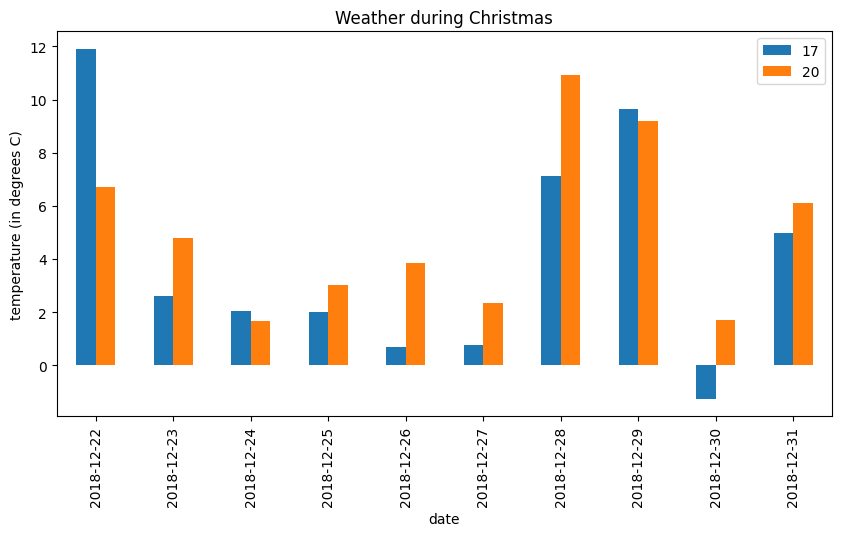

In [28]:
plt.rcParams.update({'font.size': 10})
df_weather_christmas.plot(kind='bar', figsize=(10,5))
plt.legend(loc='upper right', fontsize=10);
plt.title("Weather during Christmas");
plt.xlabel('date')
plt.ylabel('temperature (in degrees C)');

## Chirstmas Party Date and Time Proposal
- Starting time is 20:00 (based on the previous analysis)
- The date is the day when the temperature at 20:00 is highest

In [29]:
planed_party_index = df_weather_christmas[20].argmax()
df_weather_christmas.index[planed_party_index]

'2018-12-28'

It's apparent that the party should be scheduled on December 28th, starting from 20:00 to midnight. This suggestion finds further validation / supports through the ML pipelines detailed in this notebook.

<b> To obtain the forecasted power consumptions and party costs, please proceed with running all remaining cells in this notebook. 
</b> 

# 3. Foundation models

## Data

### Targets

In [30]:
class TargetExtractor(TargetDataLoader):

    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface], 
                 hourly_aggregation) -> None:
        self.sf = sf
        self.hourly_aggregation = hourly_aggregation

    def transform(self) -> PandasDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()
        
        sf3 = sf2
        if self.hourly_aggregation:
            group_sum_cols = [SF.sum(SF.col(x)).alias(x) for x in target_spark_cols]
            sf3 = (sf3
                .withColumn("timestamp", # Truncate to the timestamp when the hour starts
                        SF.date_trunc("HOUR", SF.col("timestamp")))
                .groupby(["bldg_id", "timestamp"]).agg(*group_sum_cols)
            )
        df = sf3.toPandas().sort_values(["bldg_id", "timestamp"]).reset_index(drop=True)
        df.rename(columns={c:c.replace("`", "") for c in df.columns}, inplace=True)
        return df

In [31]:
hdfs_location = target_input_dir

# All buildings
keys = list(range(1, 200+1))
keys = [str(s) for s in keys] + ["scrooge_bldg"]

target_extractor = TargetExtractor(
    TargetSelector(
        TargetDataLoader(
            spark, hdfs_location, keys, extension=".parquet"
        ),
        is_timestamp_adjusted=True,
        months_selected=foundation_config["months_selected"], 
        hours_selected=foundation_config["hours_selected"]
    ),
    hourly_aggregation=foundation_config["hourly_aggregation"]
)

df_targets = target_extractor.transform()
df_targets

24/04/10 15:50:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/04/10 15:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB


,bldg_id,timestamp,out.electricity.heating_hp_bkup.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.plug_loads.energy_consumption
0,1,2018-01-01 20:00:00,1.391000,0.532000,0.172000
1,1,2018-01-01 21:00:00,1.502000,0.532000,0.164000
2,1,2018-01-01 22:00:00,2.481000,0.532000,0.092000
3,1,2018-01-01 23:00:00,1.773000,0.528000,0.092000
4,1,2018-01-02 20:00:00,1.206000,0.532000,0.132000
...,...,...,...,...,...
138283,scrooge_bldg,2018-12-20 23:00:00,0.863286,0.590429,0.132000
138284,scrooge_bldg,2018-12-21 20:00:00,0.000000,0.383000,0.188857
138285,scrooge_bldg,2018-12-21 21:00:00,0.000000,0.351857,0.186714
138286,scrooge_bldg,2018-12-21 22:00:00,0.000000,0.381857,0.147143


### Weather

In [32]:
weather_location_dir = weather_input_dir

weather_extractor_for_party = WeatherExtractor(
    WeatherTemperatureTransformer(
        WeatherDataLoader(
            spark, weather_location_dir,
        )
    ),
    hours_selected=foundation_config["hours_selected"], minutes_selected=[0]
)
    
df_weather = weather_extractor_for_party.transform().toPandas()
df_weather = df_weather.sort_values("timestamp").reset_index(drop=True)
df_weather

,timestamp,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg
0,2018-01-01 20:00:00,-10.07,-17.07,1022,38,252.62,8.23,290
1,2018-01-01 21:00:00,-10.07,-17.07,1023,37,252.35,7.72,300
2,2018-01-01 22:00:00,-10.87,-17.87,1023,36,251.33,8.80,310
3,2018-01-01 23:00:00,-11.12,-18.12,1024,37,251.38,7.72,290
4,2018-01-02 20:00:00,-7.19,-14.19,1024,33,253.79,5.70,260
...,...,...,...,...,...,...,...,...
1455,2018-12-30 23:00:00,-1.35,-4.73,1023,60,265.80,2.60,90
1456,2018-12-31 20:00:00,6.11,2.20,1026,64,272.99,6.26,219
1457,2018-12-31 21:00:00,5.90,1.77,1025,65,273.00,6.71,188
1458,2018-12-31 22:00:00,5.17,0.68,1025,68,272.94,7.15,187


### Metadata

In [33]:
class MetadataDataLoader(TransformerInterface):

    def __init__(self, spark, hdfs_location, master_key, secondary_key,
                 extension=".parquet") -> None:
        self.spark = spark
        
        self.hdfs_location = hdfs_location
        self.master_key = master_key
        self.secondary_key = secondary_key
        self.extension = extension

    @staticmethod
    def system_type():
        return SystemType.PYSPARK

    @staticmethod
    def libraries():
        libraries = Libraries()
        return libraries

    @staticmethod
    def settings() -> dict:
        return {}

    def pre_transform_validation(self):
        return True

    def post_transform_validation(self):
        return True

    def transform(self) -> PySparkDataFrame:
        sf_master = self.spark.read.parquet(f"{self.hdfs_location}/{self.master_key}{self.extension}")
        sf_master = sf_master.withColumn("bldg_id", SF.lit("scrooge_bldg"))
        
        sf_secondary = self.spark.read.parquet(f"{self.hdfs_location}/{self.secondary_key}{self.extension}")
        
        common_cols = [c for c in sf_master.columns if c in sf_secondary.columns]
        master_cols = ["bldg_id"] +  [f"`{c}`" for c in common_cols if c != "bldg_id"]
        
        sf = sf_master.select(master_cols).union(sf_secondary.select(master_cols))
        
        return sf
    
class MetadataExtractor(MetadataDataLoader):
    def __init__(self, sf: Union[PySparkDataFrame, TransformerInterface]) -> None:
        self.sf = sf

    def transform(self) -> PySparkDataFrame:
        sf2 = self.sf
        if isinstance(self.sf, TransformerInterface):
            sf2 = self.sf.transform()
            
        return sf2

In [34]:
hdfs_location = target_input_dir

metadata_extractor = MetadataExtractor(
    MetadataDataLoader(
        spark, hdfs_location, 
        master_key="scrooge_metadata", secondary_key="metadata", extension=".parquet"
    )
)

df_meta = metadata_extractor.transform().toPandas()
df_meta = df_meta.sort_values("bldg_id").reset_index(drop=True)
df_meta

24/04/10 15:50:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,bldg_id,in.sqft,weight,in.simulation_control_run_period_begin_day_of_month,in.simulation_control_run_period_begin_month,in.simulation_control_run_period_calendar_year,in.simulation_control_run_period_end_day_of_month,in.simulation_control_run_period_end_month,in.simulation_control_timestep,in.units_represented,...,in.reeds_balancing_area,in.refrigerator,in.roof_material,in.schedules,in.solar_hot_water,in.state,in.tenure,in.usage_level,in.vacancy_status,in.water_heater_in_unit
0,1,633.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 19.9, 100% Usage",Composition Shingles,Stochastic,None,MA,Owner,Low,Occupied,Yes
1,10,8194.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 15.9, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Medium,Occupied,Yes
2,100,2176.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 15.9, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,High,Occupied,Yes
3,101,853.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 15.9, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Renter,High,Vacant,Yes
4,102,1690.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 15.9, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,High,Occupied,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,96,2663.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 17.6, 100% Usage",Composition Shingles,Stochastic,None,MA,Owner,Medium,Occupied,Yes
197,97,617.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Renter,Low,Occupied,No
198,98,1220.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 19.9, 100% Usage",Composition Shingles,Stochastic,None,MA,Owner,High,Occupied,Yes
199,99,1220.000000,242.131013,1.0,1.0,2018.0,31.0,12.0,15.0,1.0,...,131,"EF 17.6, 100% Usage",Composition Shingles,Stochastic,None,MA,Owner,High,Occupied,Yes


### Metadata feature selection

In [35]:
bldg_key_cols = ["bldg_id"]
bldg_features = [c for c in df_meta.columns if c not in bldg_key_cols]

good_cat_bldg_features = []
good_num_bldg_features = []

for c in bldg_features:
    if c in bldg_key_cols:
        continue
    if df_meta[c].unique().shape[0] == 1: # single value, drop it
        continue
        
    c_val = df_meta[df_meta["bldg_id"] == "scrooge_bldg"].iloc[0][c]
    if isinstance(c_val, str):
        if df_meta[df_meta[c] == c_val].shape[0] >= 20:
            good_cat_bldg_features.append(c)
    else:
        good_num_bldg_features.append(c)

good_bldg_features = good_cat_bldg_features + good_num_bldg_features
print(len(good_num_bldg_features), len(good_cat_bldg_features), len(good_bldg_features))

19 48 67


### Join targets, weather and metadata

In [36]:
df_train = df_targets.copy()

df_train = pd.merge( df_train, df_weather, on=["timestamp"])
df_train = pd.merge( df_train, df_meta[bldg_key_cols + good_bldg_features], on=["bldg_id"])

df_train["hour"] = df_train["timestamp"].dt.hour

view_cols = ["bldg_id", "timestamp", "hour"] + target_cols
view_cols += [c for c in df_train.columns if c not in view_cols]

df_train = df_train[view_cols]
df_train

,bldg_id,timestamp,hour,out.electricity.heating_hp_bkup.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.plug_loads.energy_consumption,temp,feels_like,pressure,humidity,...,out.params.roof_area_ft_2,out.params.size_cooling_system_primary_k_btu_h,out.params.size_heat_pump_backup_primary_k_btu_h,out.params.size_heating_system_primary_k_btu_h,out.params.size_water_heater_gal,out.params.slab_perimeter_exposed_conditioned_ft,out.params.wall_area_above_grade_conditioned_ft_2,out.params.wall_area_above_grade_exterior_ft_2,out.params.wall_area_below_grade_ft_2,out.params.window_area_ft_2
0,1,2018-01-01 20:00:00,20,1.391000,0.532000,0.172000,-10.07,-17.07,1022,38,...,353.800000,8.530000,16.080000,8.530000,50.0,74.300000,594.000000,638.000000,594.000000,53.400000
1,1,2018-01-01 21:00:00,21,1.502000,0.532000,0.164000,-10.07,-17.07,1023,37,...,353.800000,8.530000,16.080000,8.530000,50.0,74.300000,594.000000,638.000000,594.000000,53.400000
2,1,2018-01-01 22:00:00,22,2.481000,0.532000,0.092000,-10.87,-17.87,1023,36,...,353.800000,8.530000,16.080000,8.530000,50.0,74.300000,594.000000,638.000000,594.000000,53.400000
3,1,2018-01-01 23:00:00,23,1.773000,0.528000,0.092000,-11.12,-18.12,1024,37,...,353.800000,8.530000,16.080000,8.530000,50.0,74.300000,594.000000,638.000000,594.000000,53.400000
4,1,2018-01-02 20:00:00,20,1.206000,0.532000,0.132000,-7.19,-14.19,1024,33,...,353.800000,8.530000,16.080000,8.530000,50.0,74.300000,594.000000,638.000000,594.000000,53.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138283,scrooge_bldg,2018-12-20 23:00:00,23,0.863286,0.590429,0.132000,5.69,1.85,1018,70,...,1439.385714,29.004286,51.254286,29.004286,50.0,55.457143,1766.142857,2036.114286,756.885714,180.542857
138284,scrooge_bldg,2018-12-21 20:00:00,20,0.000000,0.383000,0.188857,17.43,17.76,998,97,...,1439.385714,29.004286,51.254286,29.004286,50.0,55.457143,1766.142857,2036.114286,756.885714,180.542857
138285,scrooge_bldg,2018-12-21 21:00:00,21,0.000000,0.351857,0.186714,17.66,17.96,997,95,...,1439.385714,29.004286,51.254286,29.004286,50.0,55.457143,1766.142857,2036.114286,756.885714,180.542857
138286,scrooge_bldg,2018-12-21 22:00:00,22,0.000000,0.381857,0.147143,17.99,18.33,996,95,...,1439.385714,29.004286,51.254286,29.004286,50.0,55.457143,1766.142857,2036.114286,756.885714,180.542857


## Modelling

In [37]:
key_cols = ["bldg_id", "timestamp", "hour"]

cat_cols = good_cat_bldg_features[:]
feature_cols = [c for c in df_train.columns if c not in key_cols+target_cols]


print(key_cols)
print(target_cols)

print("feature_cols:", len(feature_cols))
print(feature_cols)

print("cat_cols:", len(cat_cols))
print(cat_cols)

print()
print("Summary:")
print("key_cols:", key_cols)
print("target_cols:", target_cols)
print("#feature_cols:", len(feature_cols))
print("#cat_cols:", len(cat_cols))
    

['bldg_id', 'timestamp', 'hour']
['out.electricity.heating_hp_bkup.energy_consumption', 'out.electricity.heating.energy_consumption', 'out.electricity.plug_loads.energy_consumption']
feature_cols: 74
['temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'wind_speed', 'wind_deg', 'in.ceiling_fan', 'in.clothes_dryer', 'in.clothes_washer', 'in.clothes_washer_presence', 'in.cooking_range', 'in.corridor', 'in.geometry_attic_type', 'in.geometry_building_horizontal_location_mf', 'in.geometry_building_horizontal_location_sfa', 'in.geometry_building_level_mf', 'in.geometry_building_number_units_mf', 'in.geometry_building_number_units_sfa', 'in.geometry_building_type_acs', 'in.geometry_building_type_height', 'in.geometry_building_type_recs', 'in.geometry_floor_area_bin', 'in.geometry_story_bin', 'in.has_pv', 'in.heating_fuel', 'in.heating_setpoint_has_offset', 'in.hot_water_fixtures', 'in.hvac_has_shared_system', 'in.hvac_has_zonal_electric_heating', 'in.hvac_shared_efficiencies', 'in.insu

In [38]:
print("Baseline modelling ...")
df_pure_train = df_train[df_train["bldg_id"] != "scrooge_bldg"].reset_index(drop=True)
df_pure_val = df_train[df_train["bldg_id"] == "scrooge_bldg"].reset_index(drop=True)
    
print(df_train.shape, df_pure_train.shape, df_pure_val.shape)

Baseline modelling ...
(138288, 80) (137600, 80) (688, 80)


In [39]:
dict_models = {}
run_seeds = [None, 0, 2024]

for target_col in target_cols:
    print("-"*40)
    print(target_col)
        
    models = []
    for seed in run_seeds:
        print("-"*40)
        print("seed:", seed)

        X_train, y_train = df_pure_train[feature_cols], df_pure_train[target_col]
        X_val, y_val = df_pure_val[feature_cols], df_pure_val[target_col]

        print("Train/val:", X_train.shape, X_val.shape)
        print("Train/val:", y_train.shape, y_val.shape)
        print("Train/val:", y_train.mean(), y_val.mean())

        # loss_function = "MultiRMSE"
        loss_function = 'MultiQuantile:alpha=0.1,0.2,0.5,0.8,0.9'

        # Define CatBoost parameters
        params = {
            'iterations': 50,
            'learning_rate': 0.1,
            'loss_function': loss_function,
            'random_seed': seed
        }

        model = CatBoostRegressor(**params)

        model.fit(X_train, y_train, cat_features=cat_cols,
                  eval_set=(X_val, y_val),
                  verbose=20)
        models.append(model)
        
    dict_models[target_col] = models

----------------------------------------
out.electricity.heating_hp_bkup.energy_consumption
----------------------------------------
seed: None
Train/val: (137600, 74) (688, 74)
Train/val: (137600,) (688,)
Train/val: 0.2908940043604651 1.4048502906976745
0:	learn: 0.1336184	test: 0.5904147	best: 0.5904147 (0)	total: 295ms	remaining: 14.4s
20:	learn: 0.0731868	test: 0.5344686	best: 0.5335253 (19)	total: 4.46s	remaining: 6.16s
40:	learn: 0.0645014	test: 0.5401207	best: 0.5320782 (24)	total: 8.26s	remaining: 1.81s
49:	learn: 0.0627495	test: 0.5453692	best: 0.5320782 (24)	total: 9.93s	remaining: 0us

bestTest = 0.5320781537
bestIteration = 24

Shrink model to first 25 iterations.
----------------------------------------
seed: 0
Train/val: (137600, 74) (688, 74)
Train/val: (137600,) (688,)
Train/val: 0.2908940043604651 1.4048502906976745
0:	learn: 0.1336184	test: 0.5904147	best: 0.5904147 (0)	total: 253ms	remaining: 12.4s
20:	learn: 0.0731868	test: 0.5344686	best: 0.5335253 (19)	total: 4.32

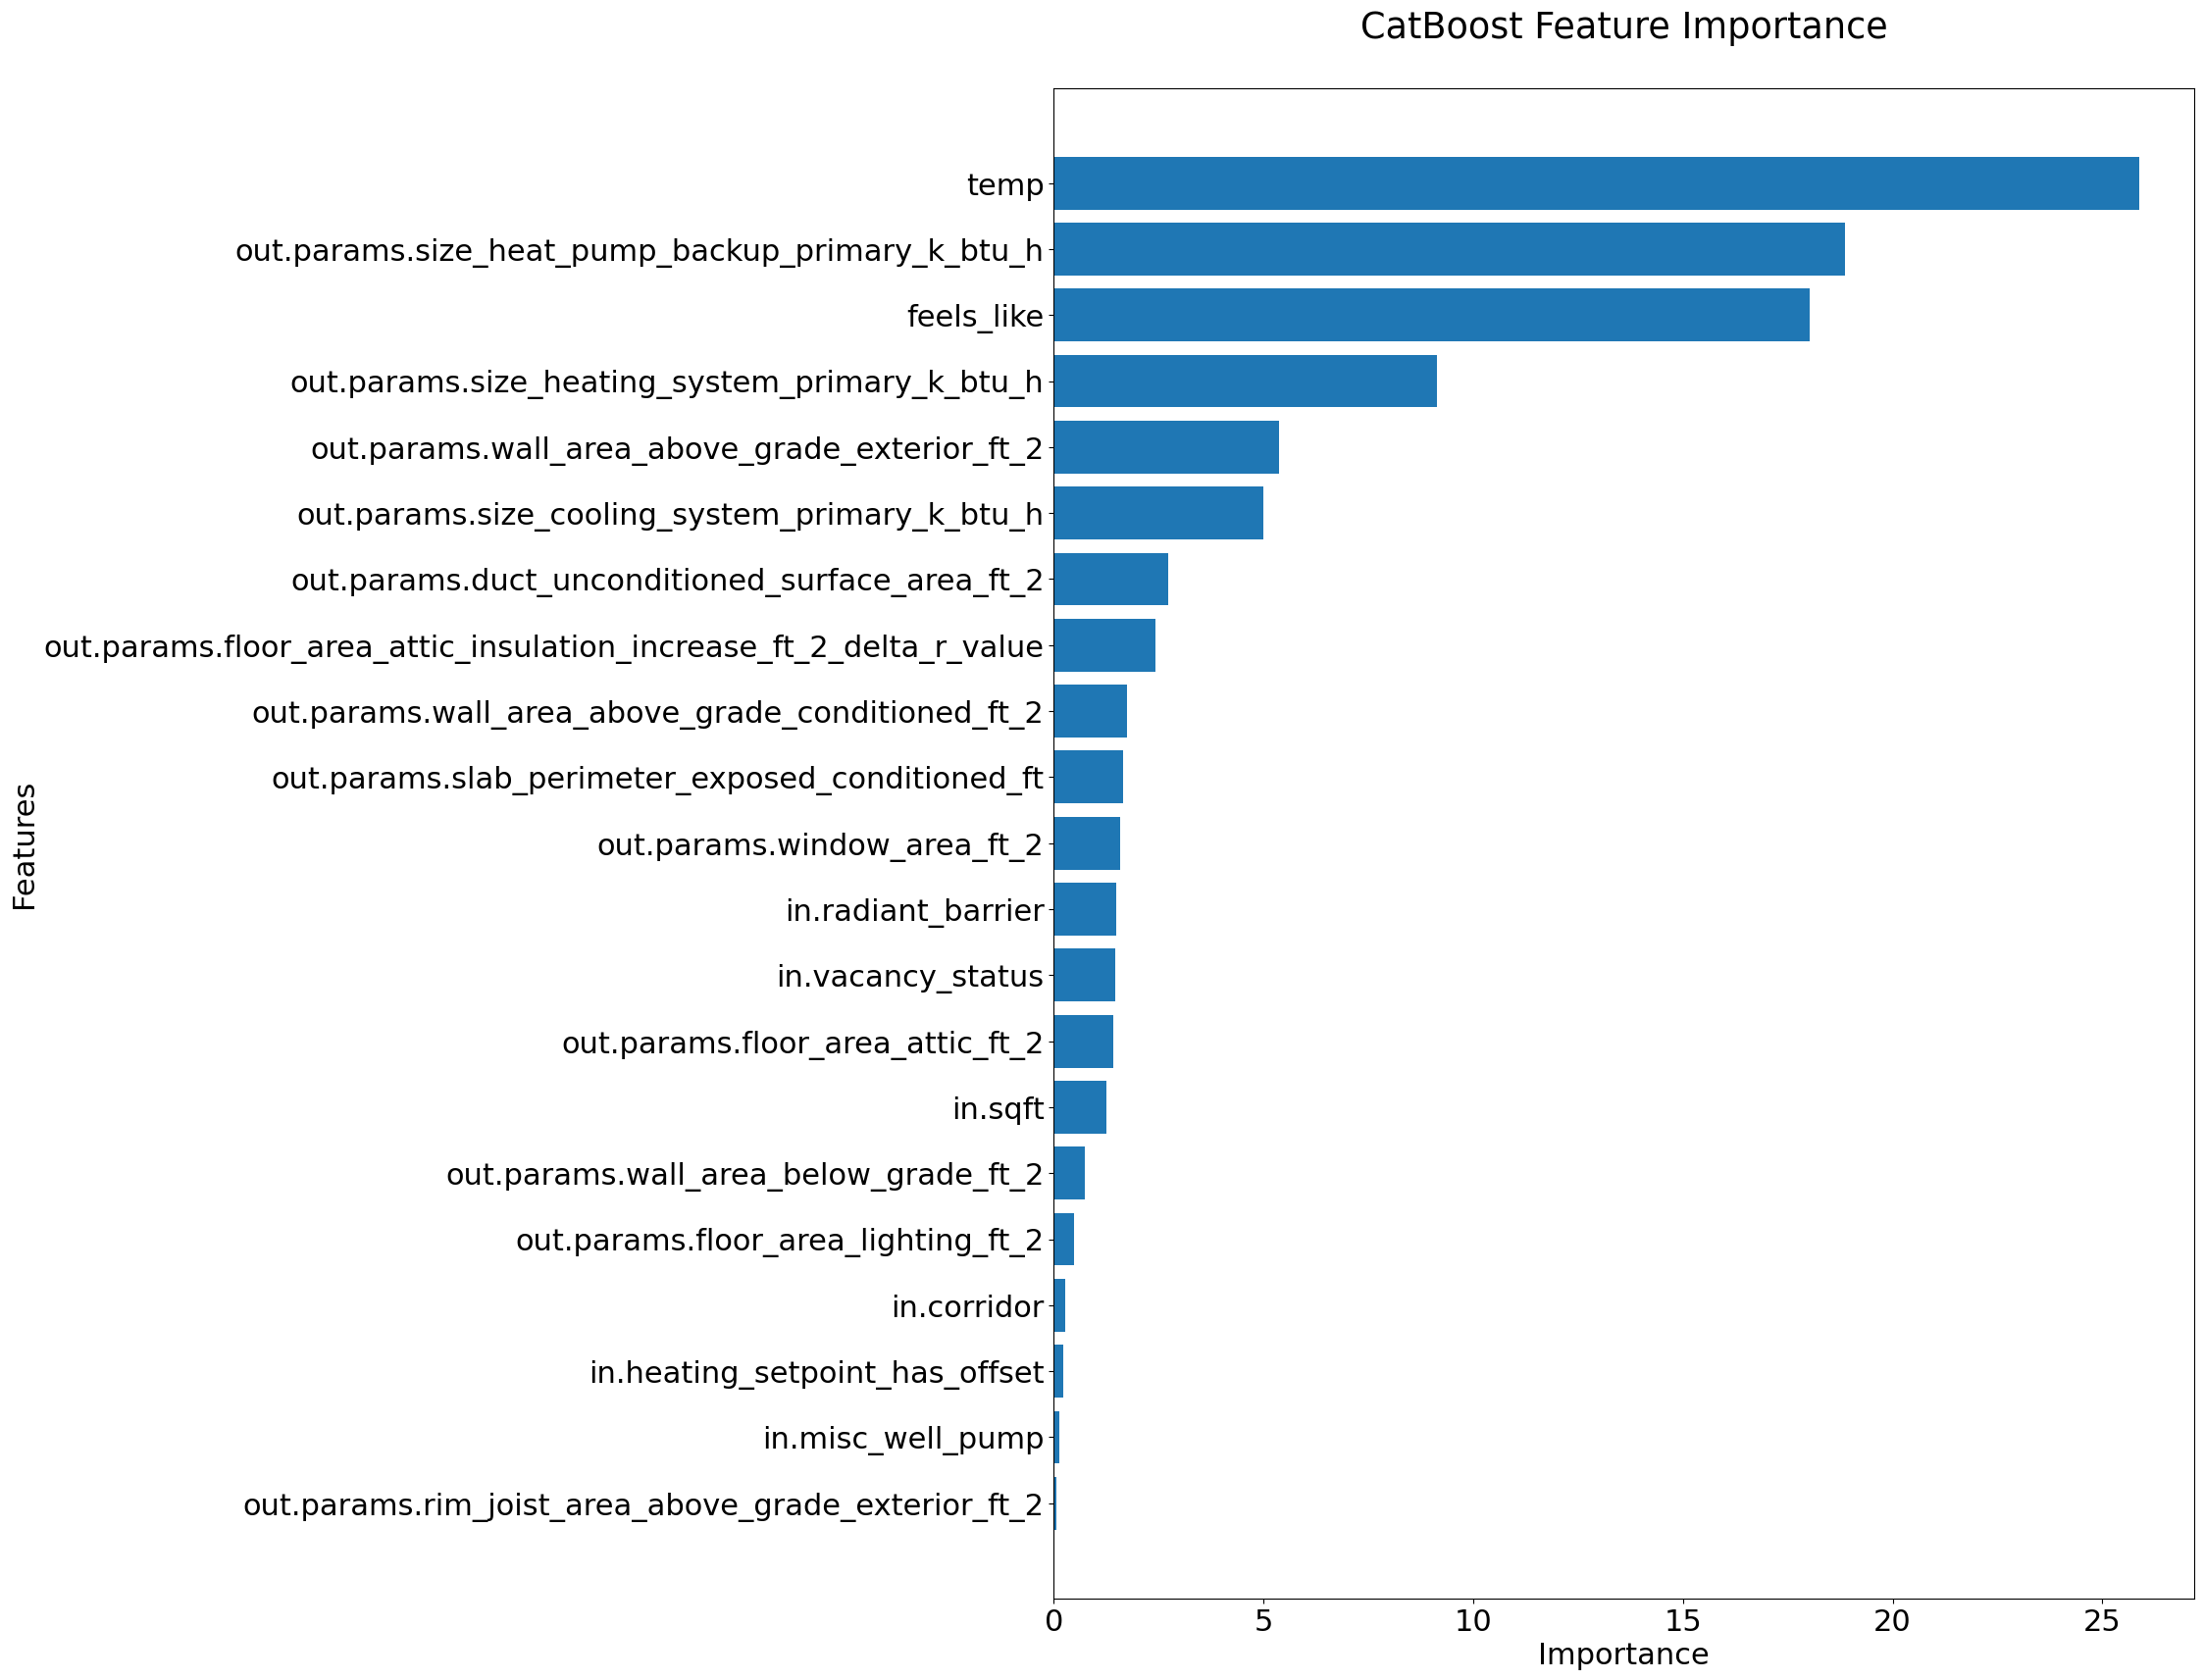

In [40]:
importances = dict_models[target_cols[0]][0].get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
feature_importances = feature_importances.to_frame("importance").reset_index()
feature_importances = feature_importances.sort_values("importance", ascending=False)\
    .reset_index(drop=True)
feature_importances.head(10)

top_feature_importances = feature_importances[feature_importances["importance"] >= 1e-3]\
    .sort_values("importance")

# top_feature_importances = feature_importances.head(50).sort_values("importance")

plt.figure(figsize=(15, 20))
plt.rcParams.update({'font.size': 22})
plt.barh(top_feature_importances["index"], top_feature_importances["importance"])
plt.title('CatBoost Feature Importance\n')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Save

In [41]:
dict_foundation = {
    "feature_cols": feature_cols,
    "cat_cols": cat_cols,
    "dict_models": dict_models
}

print(dict_foundation_filename)
with open(dict_foundation_filename, 'wb') as handle:
    pickle.dump(dict_foundation, handle)

workspace/models/dict_foundation_quantile.pickle


# 4. Scrooge models

## Data

### Targets

In [42]:
hdfs_location = target_input_dir

keys = ["scrooge_bldg"]

target_extractor = TargetExtractor(
    TargetSelector(
        TargetDataLoader(
            spark, hdfs_location, keys, extension=".parquet"
        ),
        is_timestamp_adjusted=True,
        months_selected=scrooge_config["months_selected"], 
        hours_selected=scrooge_config["hours_selected"]
    ),
    hourly_aggregation=scrooge_config["hourly_aggregation"]
)

df_targets = target_extractor.transform()
df_targets

,bldg_id,timestamp,out.electricity.heating_hp_bkup.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.plug_loads.energy_consumption
0,scrooge_bldg,2018-01-01 20:00:00,6.794143,1.585000,0.187286
1,scrooge_bldg,2018-01-01 21:00:00,6.963143,1.610571,0.173714
2,scrooge_bldg,2018-01-01 22:00:00,7.608714,1.629429,0.148000
3,scrooge_bldg,2018-01-01 23:00:00,7.246857,1.647286,0.136000
4,scrooge_bldg,2018-01-02 20:00:00,5.969571,1.596714,0.186143
...,...,...,...,...,...
1415,scrooge_bldg,2018-12-20 23:00:00,0.863286,0.590429,0.132000
1416,scrooge_bldg,2018-12-21 20:00:00,0.000000,0.383000,0.188857
1417,scrooge_bldg,2018-12-21 21:00:00,0.000000,0.351857,0.186714
1418,scrooge_bldg,2018-12-21 22:00:00,0.000000,0.381857,0.147143


In [43]:
with open(dict_foundation_filename, 'rb') as handle:
    baseline_foundation = pickle.load(handle)
print(baseline_foundation.keys())

feature_cols = baseline_foundation["feature_cols"]
print(feature_cols)

cat_cols = baseline_foundation["cat_cols"]
print(cat_cols)

dict_keys(['feature_cols', 'cat_cols', 'dict_models'])
['temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'wind_speed', 'wind_deg', 'in.ceiling_fan', 'in.clothes_dryer', 'in.clothes_washer', 'in.clothes_washer_presence', 'in.cooking_range', 'in.corridor', 'in.geometry_attic_type', 'in.geometry_building_horizontal_location_mf', 'in.geometry_building_horizontal_location_sfa', 'in.geometry_building_level_mf', 'in.geometry_building_number_units_mf', 'in.geometry_building_number_units_sfa', 'in.geometry_building_type_acs', 'in.geometry_building_type_height', 'in.geometry_building_type_recs', 'in.geometry_floor_area_bin', 'in.geometry_story_bin', 'in.has_pv', 'in.heating_fuel', 'in.heating_setpoint_has_offset', 'in.hot_water_fixtures', 'in.hvac_has_shared_system', 'in.hvac_has_zonal_electric_heating', 'in.hvac_shared_efficiencies', 'in.insulation_floor', 'in.insulation_foundation_wall', 'in.insulation_rim_joist', 'in.insulation_roof', 'in.insulation_slab', 'in.misc_gas_fireplace', '

### Weather

In [44]:
weather_location_dir = weather_input_dir

weather_extractor_for_party = WeatherExtractor(
    WeatherTemperatureTransformer(
        WeatherDataLoader(
            spark, weather_location_dir,
        )
    ),
    hours_selected=scrooge_config["hours_selected"], minutes_selected=[0]
)
    
df_weather = weather_extractor_for_party.transform().toPandas()
df_weather = df_weather.sort_values("timestamp").reset_index(drop=True)
df_weather

,timestamp,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg
0,2018-01-01 20:00:00,-10.07,-17.07,1022,38,252.62,8.23,290
1,2018-01-01 21:00:00,-10.07,-17.07,1023,37,252.35,7.72,300
2,2018-01-01 22:00:00,-10.87,-17.87,1023,36,251.33,8.80,310
3,2018-01-01 23:00:00,-11.12,-18.12,1024,37,251.38,7.72,290
4,2018-01-02 20:00:00,-7.19,-14.19,1024,33,253.79,5.70,260
...,...,...,...,...,...,...,...,...
1455,2018-12-30 23:00:00,-1.35,-4.73,1023,60,265.80,2.60,90
1456,2018-12-31 20:00:00,6.11,2.20,1026,64,272.99,6.26,219
1457,2018-12-31 21:00:00,5.90,1.77,1025,65,273.00,6.71,188
1458,2018-12-31 22:00:00,5.17,0.68,1025,68,272.94,7.15,187


## Inference based on the foundation models

In [45]:
with open(dict_foundation_filename, 'rb') as handle:
    baseline_foundation = pickle.load(handle)
print(baseline_foundation.keys())

feature_cols = baseline_foundation["feature_cols"]
print(feature_cols)

cat_cols = baseline_foundation["cat_cols"]
print(cat_cols)

dict_keys(['feature_cols', 'cat_cols', 'dict_models'])
['temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'wind_speed', 'wind_deg', 'in.ceiling_fan', 'in.clothes_dryer', 'in.clothes_washer', 'in.clothes_washer_presence', 'in.cooking_range', 'in.corridor', 'in.geometry_attic_type', 'in.geometry_building_horizontal_location_mf', 'in.geometry_building_horizontal_location_sfa', 'in.geometry_building_level_mf', 'in.geometry_building_number_units_mf', 'in.geometry_building_number_units_sfa', 'in.geometry_building_type_acs', 'in.geometry_building_type_height', 'in.geometry_building_type_recs', 'in.geometry_floor_area_bin', 'in.geometry_story_bin', 'in.has_pv', 'in.heating_fuel', 'in.heating_setpoint_has_offset', 'in.hot_water_fixtures', 'in.hvac_has_shared_system', 'in.hvac_has_zonal_electric_heating', 'in.hvac_shared_efficiencies', 'in.insulation_floor', 'in.insulation_foundation_wall', 'in.insulation_rim_joist', 'in.insulation_roof', 'in.insulation_slab', 'in.misc_gas_fireplace', '

In [46]:
df_inference = df_weather.copy()
    
df_inference["bldg_id"] = "scrooge_bldg"
df_inference = pd.merge( df_inference, df_meta, on=["bldg_id"])
df_inference["hour"] = df_inference["timestamp"].dt.hour

print("Missing features:", [c for c in feature_cols if c not in df_inference.columns])
df_inference

Missing features: []


,timestamp,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg,bldg_id,in.sqft,...,in.refrigerator,in.roof_material,in.schedules,in.solar_hot_water,in.state,in.tenure,in.usage_level,in.vacancy_status,in.water_heater_in_unit,hour
0,2018-01-01 20:00:00,-10.07,-17.07,1022,38,252.62,8.23,290,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,20
1,2018-01-01 21:00:00,-10.07,-17.07,1023,37,252.35,7.72,300,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,21
2,2018-01-01 22:00:00,-10.87,-17.87,1023,36,251.33,8.80,310,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,22
3,2018-01-01 23:00:00,-11.12,-18.12,1024,37,251.38,7.72,290,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,23
4,2018-01-02 20:00:00,-7.19,-14.19,1024,33,253.79,5.70,260,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2018-12-30 23:00:00,-1.35,-4.73,1023,60,265.80,2.60,90,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,23
1456,2018-12-31 20:00:00,6.11,2.20,1026,64,272.99,6.26,219,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,20
1457,2018-12-31 21:00:00,5.90,1.77,1025,65,273.00,6.71,188,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,21
1458,2018-12-31 22:00:00,5.17,0.68,1025,68,272.94,7.15,187,scrooge_bldg,1831.142857,...,"EF 17.6, 100% Usage","Asphalt Shingles, Medium",Stochastic,None,MA,Owner,Low,Occupied,Yes,22


In [47]:
loss_function = 'MultiQuantile:alpha=0.1,0.2,0.5,0.8,0.9'

quantiles = loss_function.split("=")[-1]
quantiles = [float(e) for e in quantiles.split(",")]
print(quantiles)

df_pred_level1 = df_inference[key_cols].copy()
dict_models = baseline_foundation["dict_models"]

for i, target_col in enumerate(target_cols):
    X_pred = df_inference[feature_cols]
    
    seed_models = dict_models[target_col]
    y_pred = []
    for model in seed_models:
        y_pred.append(model.predict(X_pred))
    y_pred = np.mean(np.array(y_pred), axis=0)
    
    for i, q in enumerate(quantiles):
        if q != 0.5:
            continue 
        pred_col = f"pred_{target_col}".replace(".", "")
        df_pred_level1[pred_col] = y_pred[:,i]

df_pred_level1[df_pred_level1["timestamp"] >= "2018-12-28"].head()

[0.1, 0.2, 0.5, 0.8, 0.9]


,bldg_id,timestamp,hour,pred_outelectricityheating_hp_bkupenergy_consumption,pred_outelectricityheatingenergy_consumption,pred_outelectricityplug_loadsenergy_consumption
1444,scrooge_bldg,2018-12-28 20:00:00,20,4.661001e-08,0.322592,0.139154
1445,scrooge_bldg,2018-12-28 21:00:00,21,4.661001e-08,0.305154,0.138968
1446,scrooge_bldg,2018-12-28 22:00:00,22,4.661001e-08,0.279439,0.137695
1447,scrooge_bldg,2018-12-28 23:00:00,23,4.661001e-08,0.224775,0.138888
1448,scrooge_bldg,2018-12-29 20:00:00,20,7.487529e-09,0.460396,0.137616


## Train and Test sets 
These sets are for the Scrooge models

In [48]:
df_train_level2 = df_targets.copy()

df_train_level2["hour"] = df_train_level2["timestamp"].dt.hour
df_train_level2 = pd.merge( df_train_level2, df_weather, on=["timestamp"])
df_train_level2 = pd.merge( df_train_level2, df_pred_level1, on=key_cols)

view_cols = key_cols + [c for c in df_train_level2.columns if c not in key_cols]

df_train_level2 = df_train_level2[view_cols].copy()
print(df_train_level2.shape)
df_train_level2

(1420, 16)


,bldg_id,timestamp,hour,out.electricity.heating_hp_bkup.energy_consumption,out.electricity.heating.energy_consumption,out.electricity.plug_loads.energy_consumption,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg,pred_outelectricityheating_hp_bkupenergy_consumption,pred_outelectricityheatingenergy_consumption,pred_outelectricityplug_loadsenergy_consumption
0,scrooge_bldg,2018-01-01 20:00:00,20,6.794143,1.585000,0.187286,-10.07,-17.07,1022,38,252.62,8.23,290,2.788994e+00,1.289725,0.151181
1,scrooge_bldg,2018-01-01 21:00:00,21,6.963143,1.610571,0.173714,-10.07,-17.07,1023,37,252.35,7.72,300,2.788994e+00,1.289725,0.151582
2,scrooge_bldg,2018-01-01 22:00:00,22,7.608714,1.629429,0.148000,-10.87,-17.87,1023,36,251.33,8.80,310,2.788994e+00,1.290930,0.151582
3,scrooge_bldg,2018-01-01 23:00:00,23,7.246857,1.647286,0.136000,-11.12,-18.12,1024,37,251.38,7.72,290,2.788994e+00,1.289725,0.151705
4,scrooge_bldg,2018-01-02 20:00:00,20,5.969571,1.596714,0.186143,-7.19,-14.19,1024,33,253.79,5.70,260,1.007368e+00,1.273433,0.147242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,scrooge_bldg,2018-12-20 23:00:00,23,0.863286,0.590429,0.132000,5.69,1.85,1018,70,273.80,5.81,184,6.083335e-04,0.661306,0.140292
1416,scrooge_bldg,2018-12-21 20:00:00,20,0.000000,0.383000,0.188857,17.43,17.76,998,97,290.10,15.65,170,4.661001e-08,0.057227,0.144341
1417,scrooge_bldg,2018-12-21 21:00:00,21,0.000000,0.351857,0.186714,17.66,17.96,997,95,290.00,17.88,170,4.661001e-08,0.057245,0.144341
1418,scrooge_bldg,2018-12-21 22:00:00,22,0.000000,0.381857,0.147143,17.99,18.33,996,95,290.33,15.65,171,4.661001e-08,0.054361,0.144341


In [49]:
df_test_level2 = df_weather[df_weather["timestamp"] > "2018-12-22"].reset_index(drop=True)

df_test_level2["hour"] = df_test_level2["timestamp"].dt.hour
df_test_level2["bldg_id"] = "scrooge_bldg"
df_test_level2 = pd.merge( df_test_level2, df_pred_level1, on=key_cols)

view_cols = key_cols + [c for c in df_test_level2.columns if c not in key_cols]
df_test_level2 = df_test_level2[view_cols].copy()

df_test_level2.tail(5)

,bldg_id,timestamp,hour,temp,feels_like,pressure,humidity,dew_point,wind_speed,wind_deg,pred_outelectricityheating_hp_bkupenergy_consumption,pred_outelectricityheatingenergy_consumption,pred_outelectricityplug_loadsenergy_consumption
35,scrooge_bldg,2018-12-30 23:00:00,23,-1.35,-4.73,1023,60,265.80,2.60,90,0.263344,1.038971,0.144526
36,scrooge_bldg,2018-12-31 20:00:00,20,6.11,2.20,1026,64,272.99,6.26,219,0.000608,0.653943,0.144746
37,scrooge_bldg,2018-12-31 21:00:00,21,5.90,1.77,1025,65,273.00,6.71,188,0.000608,0.670459,0.146344
38,scrooge_bldg,2018-12-31 22:00:00,22,5.17,0.68,1025,68,272.94,7.15,187,0.000608,0.714768,0.147797
39,scrooge_bldg,2018-12-31 23:00:00,23,4.66,0.54,1024,70,272.85,5.81,186,0.000608,0.714902,0.144207


## Modelling and Predictions

In [50]:
loss_function = "RMSE"

params = {
    'iterations': 2000, 
    'learning_rate': 0.1,
    'loss_function': loss_function,
    'random_seed': SEED
}

In [51]:
dict_models_level2 = {}
dict_features_level2 = {}

df_pure_train = df_train_level2
df_pure_val = df_train_level2

df_pred_level2 = df_test_level2[key_cols].copy()
ti_cols = []

for ti, target_col in enumerate(target_cols):
    print("-"*40)
    print(target_col)
    
    # feature_cols_level2 = [f"pred_q{q}_{target_col}".replace(".", "") for q in [0.5]]
    # feature_cols_level2 += [f"avg7_{target_col}", "temp"]
    feature_cols_level2 = [f"pred_{target_col}".replace(".", "") for q in [0.5]]
    feature_cols_level2 += ["temp"]
    
    X_train, y_train = df_pure_train[feature_cols_level2], df_pure_train[target_col]
    X_val, y_val = df_pure_val[feature_cols_level2], df_pure_val[target_col]

    print("Train/val:", X_train.shape, X_val.shape)
    print("Train/val:", y_train.shape, y_val.shape)
    print("Train/val:", y_train.mean(), y_val.mean())

    model = CatBoostRegressor(**params)

    # model.fit(X_train, y_train, cat_features=cat_cols_level2, eval_set=(X_val, y_val), verbose=20)
    model.fit(X_train, y_train, verbose=500)
    
    dict_models_level2[target_col] = model
    dict_features_level2[target_col] = feature_cols_level2[:]
    
    # Inference
    X_test = df_test_level2[feature_cols_level2]
    y_pred = model.predict(X_test)
    pred_col = f"p_{ti}"
    df_pred_level2[pred_col] = y_pred
    ti_cols.append(pred_col)
    
# clear_output()

print("Train/val:", X_train.shape, X_val.shape)

df_pred_level2["total"] = df_pred_level2[ti_cols].sum(axis=1)
df_pred_level2["date"] = df_pred_level2["timestamp"].dt.date
df_pred_level2["date"] = df_pred_level2["date"].astype(str)
df_pred_level2[df_pred_level2["hour"] == 20]

----------------------------------------
out.electricity.heating_hp_bkup.energy_consumption
Train/val: (1420, 2) (1420, 2)
Train/val: (1420,) (1420,)
Train/val: 0.7339297786720321 0.7339297786720321
0:	learn: 1.0834430	total: 1.13ms	remaining: 2.25s
500:	learn: 0.3186389	total: 531ms	remaining: 1.59s
1000:	learn: 0.2994109	total: 993ms	remaining: 991ms
1500:	learn: 0.2933017	total: 1.46s	remaining: 484ms
1999:	learn: 0.2911828	total: 1.92s	remaining: 0us
----------------------------------------
out.electricity.heating.energy_consumption
Train/val: (1420, 2) (1420, 2)
Train/val: (1420,) (1420,)
Train/val: 0.4195444668008048 0.4195444668008048
0:	learn: 0.4026280	total: 1.08ms	remaining: 2.15s
500:	learn: 0.0660437	total: 463ms	remaining: 1.39s
1000:	learn: 0.0560279	total: 925ms	remaining: 923ms
1500:	learn: 0.0511721	total: 1.39s	remaining: 461ms
1999:	learn: 0.0476549	total: 1.85s	remaining: 0us
----------------------------------------
out.electricity.plug_loads.energy_consumption
Tra

,bldg_id,timestamp,hour,p_0,p_1,p_2,total,date
0,scrooge_bldg,2018-12-22 20:00:00,20,0.823422,0.824589,0.143091,1.791103,2018-12-22
4,scrooge_bldg,2018-12-23 20:00:00,20,1.169036,0.859258,0.160154,2.188448,2018-12-23
8,scrooge_bldg,2018-12-24 20:00:00,20,2.613646,1.048684,0.138826,3.801155,2018-12-24
12,scrooge_bldg,2018-12-25 20:00:00,20,1.493312,0.985755,0.138005,2.617072,2018-12-25
16,scrooge_bldg,2018-12-26 20:00:00,20,2.258802,0.918324,0.179299,3.356426,2018-12-26
20,scrooge_bldg,2018-12-27 20:00:00,20,1.598384,0.972848,0.161948,2.733180,2018-12-27
24,scrooge_bldg,2018-12-28 20:00:00,20,0.886999,0.493249,0.161324,1.541571,2018-12-28
28,scrooge_bldg,2018-12-29 20:00:00,20,0.897130,0.669415,0.143047,1.709593,2018-12-29
32,scrooge_bldg,2018-12-30 20:00:00,20,2.613646,1.068764,0.155182,3.837592,2018-12-30
36,scrooge_bldg,2018-12-31 20:00:00,20,0.806798,0.631194,0.142936,1.580927,2018-12-31


### Save

In [52]:
dict_model_scrooge_bldg = {
    "dict_features_level2": dict_features_level2,
    "dict_models_level2": dict_models_level2
}

print(dict_model_scrooge_bldg_filename)
with open(dict_model_scrooge_bldg_filename, 'wb') as handle:
    pickle.dump(dict_model_scrooge_bldg, handle)

workspace/models/dict_model_scrooge_bldg.pickle


# 5. Party cost and Submission

## Party (estimated) cost and the most cost-effective date

In [53]:
def get_party_cost(df, power_col="power_origin", addition_power_per_row=2):
    # Scrooge's subscribed ToU tariff is outlined as: 
    # From 6:00 pm to 10:00 pm, the rate is USD 0.35 per kWh; 
    # outside of this period, the rate stands at USD 0.20 per kWh".
    
    df_pred_cost = df.copy()

    if power_col != "power_origin":
        df_pred_cost["power_origin"] = df_pred_cost[power_col]
        
    df_pred_cost["pick_hour"] = (df_pred_cost["hour"].isin([18,19,20,21])).astype(int)
    df_pred_cost["power_price"] = df_pred_cost["pick_hour"].map({1:0.35, 0:0.2})
    
    df_pred_cost["power_increased"] = df_pred_cost[power_col] * 0.3
    df_pred_cost["power_party"] = df_pred_cost["power_increased"] + addition_power_per_row # 2 kw / hour
    df_pred_cost["party_cost"] = (df_pred_cost["power_party"] * df_pred_cost["power_price"])
    
    return df_pred_cost

In [54]:
df_pred_cost = df_pred_level2[["date", "hour", "total"]].copy()
df_pred_cost = get_party_cost(df_pred_cost, power_col="total")
df_pred_cost

,date,hour,total,power_origin,pick_hour,power_price,power_increased,power_party,party_cost
0,2018-12-22,20,1.791103,1.791103,1,0.35,0.537331,2.537331,0.888066
1,2018-12-22,21,2.663817,2.663817,1,0.35,0.799145,2.799145,0.979701
2,2018-12-22,22,2.368009,2.368009,0,0.20,0.710403,2.710403,0.542081
3,2018-12-22,23,2.763077,2.763077,0,0.20,0.828923,2.828923,0.565785
4,2018-12-23,20,2.188448,2.188448,1,0.35,0.656534,2.656534,0.929787
5,2018-12-23,21,2.801744,2.801744,1,0.35,0.840523,2.840523,0.994183
6,2018-12-23,22,2.837811,2.837811,0,0.20,0.851343,2.851343,0.570269
7,2018-12-23,23,3.152477,3.152477,0,0.20,0.945743,2.945743,0.589149
8,2018-12-24,20,3.801155,3.801155,1,0.35,1.140347,3.140347,1.099121
9,2018-12-24,21,3.035832,3.035832,1,0.35,0.910750,2.910750,1.018762


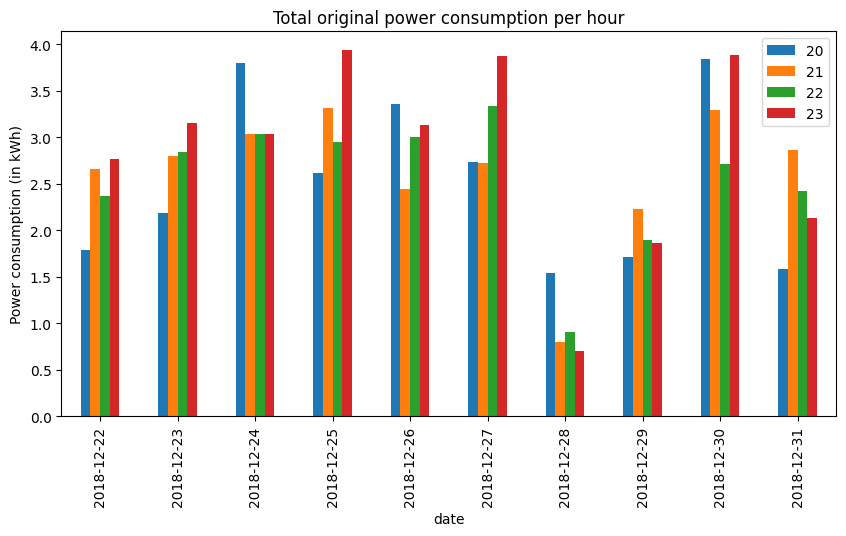

In [55]:
df_pred_cost_hourly = df_pred_cost.pivot(index='date', columns='hour', values='power_origin')
plt.rcParams.update({'font.size': 10})
df_pred_cost_hourly.plot(kind='bar', figsize=(10,5))

plt.legend(loc='upper right', fontsize=10)

plt.title("Total original power consumption per hour");
plt.xlabel('date')
plt.ylabel('Power consumption (in kWh)')
plt.show()

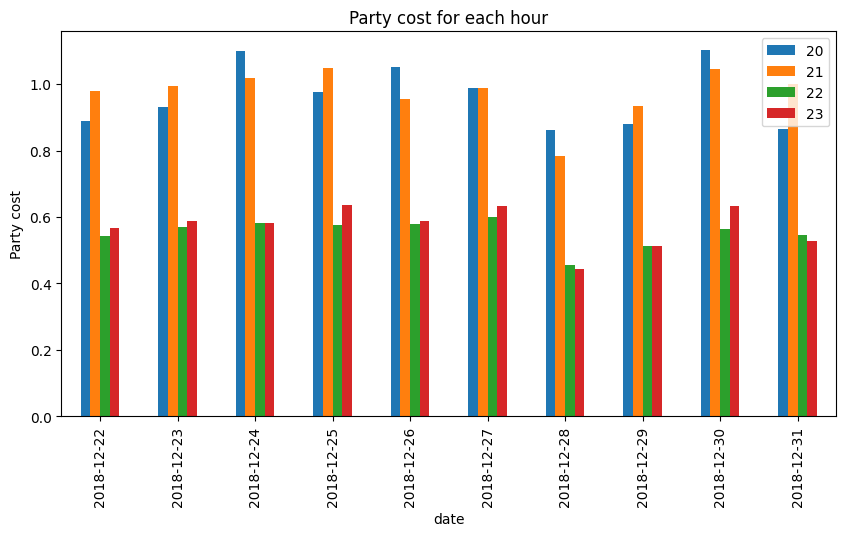

In [56]:
df_pred_cost_hourly = df_pred_cost.pivot(index='date', columns='hour', values='party_cost')
plt.rcParams.update({'font.size': 10})
df_pred_cost_hourly.plot(kind='bar', figsize=(10,5))
plt.legend(loc='upper right', fontsize=10)

plt.title("Party cost for each hour");
plt.xlabel('date')
plt.ylabel('Party cost')
plt.show()

In [57]:
df_cost_date = df_pred_cost.groupby("date")["party_cost"].sum()
print(df_cost_date)
date_min_index = df_cost_date.argmin()
date_min = list(df_cost_date.index)[date_min_index]
print("-"*40)
print("Party date selected is", date_min)

df_pred_level2[df_pred_level2["date"] == date_min]

date
2018-12-22    2.975632
2018-12-23    3.083387
2018-12-24    3.282334
2018-12-25    3.236507
2018-12-26    3.177364
2018-12-27    3.206689
2018-12-28    2.542849
2018-12-29    2.839657
2018-12-30    3.345577
2018-12-31    2.939851
Name: party_cost, dtype: float64
----------------------------------------
Party date selected is 2018-12-28


,bldg_id,timestamp,hour,p_0,p_1,p_2,total,date
24,scrooge_bldg,2018-12-28 20:00:00,20,0.886999,0.493249,0.161324,1.541571,2018-12-28
25,scrooge_bldg,2018-12-28 21:00:00,21,0.232931,0.415094,0.155496,0.803521,2018-12-28
26,scrooge_bldg,2018-12-28 22:00:00,22,0.352399,0.404739,0.146405,0.903542,2018-12-28
27,scrooge_bldg,2018-12-28 23:00:00,23,0.210652,0.344192,0.151859,0.706703,2018-12-28


## Submission

### Interpolation

In [58]:
def interpolate0_equally_divide(a, b, value):
    sub_values = [a, a, a, a]

    sub_total = sum(sub_values)
    ratio = value / sub_total
    sub_values = [v * ratio for v in sub_values]
    return sub_values
    
def interpolate4_ab(a, b, value):
    sub_values = [a, a*3/4+b*1/4, a*2/4+b*2/4, a*1/4+b*3/4]

    sub_total = sum(sub_values)
    ratio = value / sub_total
    sub_values = [v * ratio for v in sub_values]
    return sub_values

def interpolate8_ab(a, b, value):
    delta = (a-b)
    sub_values = [a, a-delta*4/8, a-delta*6/8, a-delta*7/8]

    sub_total = sum(sub_values)
    ratio = value / sub_total
    sub_values = [v * ratio for v in sub_values]
    return sub_values
    
interpolate_final = interpolate8_ab

sub_power_consumption = df_pred_level2[df_pred_level2["date"] == date_min].copy()
sub_power_consumption = sub_power_consumption.sort_values("timestamp").reset_index(drop=True)
sub_power_consumption = list(sub_power_consumption["total"])[-4:]
print(sub_power_consumption)

sub_power_consumption_details = []
for i in range(len(sub_power_consumption)): 
    if i < len(sub_power_consumption)-1:
        sub_values = interpolate_final(sub_power_consumption[i], sub_power_consumption[i+1], 
                                     sub_power_consumption[i])
    else: # The last one
        sub_values = interpolate_final(sub_power_consumption[i-1], sub_power_consumption[i], 
                                     sub_power_consumption[i])
    sub_power_consumption_details += sub_values

sub_power_consumption_details = np.round(sub_power_consumption_details, 5)
print(sub_power_consumption_details)

[1.541571164970288, 0.8035207143016334, 0.9035422924675657, 0.7067032323060318]
[0.51685 0.39313 0.33126 0.30033 0.18842 0.20015 0.20601 0.20894 0.25545
 0.22762 0.21371 0.20676 0.1998  0.17804 0.16715 0.16171]


### Submission creation

In [59]:
def sub_generator(start_datetime, sub_power_consumption_details):
    # Convert start_datetime to a datetime object if it's a string
    if isinstance(start_datetime, str):
        start_datetime = datetime.datetime.strptime(start_datetime, '%Y-%m-%d %H:%M:%S')

    # Generate the timestamp values
    timestamps = pd.date_range(start=start_datetime, periods=16, freq='15T')
    df = pd.DataFrame({'timestamp': timestamps})
    
    df["hour"] = (df["timestamp"] - pd.Timedelta(minutes=15)).dt.hour
    df["power_origin"] = sub_power_consumption_details
    df = get_party_cost(df, power_col="power_origin", addition_power_per_row=2/4)
    
    return df

start_datetime = f'{date_min} 20:15:00'
df_sub = sub_generator(start_datetime, sub_power_consumption_details)
df_sub

,timestamp,hour,power_origin,pick_hour,power_price,power_increased,power_party,party_cost
0,2018-12-28 20:15:00,20,0.51685,1,0.35,0.155055,0.655055,0.229269
1,2018-12-28 20:30:00,20,0.39313,1,0.35,0.117939,0.617939,0.216279
2,2018-12-28 20:45:00,20,0.33126,1,0.35,0.099378,0.599378,0.209782
3,2018-12-28 21:00:00,20,0.30033,1,0.35,0.090099,0.590099,0.206535
4,2018-12-28 21:15:00,21,0.18842,1,0.35,0.056526,0.556526,0.194784
5,2018-12-28 21:30:00,21,0.20015,1,0.35,0.060045,0.560045,0.196016
6,2018-12-28 21:45:00,21,0.20601,1,0.35,0.061803,0.561803,0.196631
7,2018-12-28 22:00:00,21,0.20894,1,0.35,0.062682,0.562682,0.196939
8,2018-12-28 22:15:00,22,0.25545,0,0.20,0.076635,0.576635,0.115327
9,2018-12-28 22:30:00,22,0.22762,0,0.20,0.068286,0.568286,0.113657


In [60]:
print(sub_filename)
df_sub[["timestamp", "party_cost"]].round(5).to_csv(sub_filename, index=None) # 0.0128

workspace/subs/sub_scrooge_bldg_party.csv
